In [1]:
import os 
import pandas as pd 
import torch 
import torch.nn as nn 
import numpy as np 
import networkx as nx 
from torch_geometric.data import InMemoryDataset, Data
# from prep_mhealth import prep_mhealth
# from prep_wisdm import prep_wisdm
from torch.nn import Linear 
import torch.optim as optim 
from torch_geometric.nn import GCNConv
import time
import tqdm 
import random
import copy
from torch_geometric.data import DataLoader
# from model_utils import * 
import datetime as dttm 
import argparse
from mlflow import log_metric, log_param, log_artifacts
import mlflow 

In [2]:
os.getcwd()
os.chdir('../scripts')
from prep_mhealth import prep_mhealth
from prep_wisdm import prep_wisdm
from model_utils import * 
os.chdir('../')

In [3]:
os.getcwd()

'c:\\Users\\abhi\\Documents\\GEEK\\GNN\\ours'

In [4]:
prep_wisdm(128, 1, 0.7)

100%|██████████| 36/36 [00:46<00:00,  1.30s/it]Data preparation finished. 



In [5]:
def train(data, criterion):
    model.train()
    optimizer.zero_grad()  
    out = model(data.x, data.edge_index)
    y = data.y.squeeze().t() - 1
    loss = criterion(out[data.train_mask], y[data.train_mask]  ) 
    accuracy = torch.mean((torch.argmax(out[~data.train_mask] , 1) == y[~data.train_mask]).float())
    loss.backward() 
    optimizer.step()  
    return loss

def evaluate(data): 
        model.eval()
        y = data.y.squeeze().t() - 1
        out = model(data.x, data.edge_index)  
        accuracy = torch.mean((torch.argmax(out[~data.train_mask] , 1) == y[~data.train_mask]).float())
        return accuracy

In [6]:
num_class = 6
input_dim = 9
BATCH_SIZE = 12
DATADIR  = 'data/processed/wisdm'
dataset  = HARDataCentral(DATADIR)
model = GCN_wisdm(input_dim, num_class)

In [7]:
model

GCN_wisdm(
  (conv1): GCNConv(9, 256)
  (dropout): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=6, bias=True)
)

In [8]:
loader = DataLoader(dataset, batch_size= BATCH_SIZE, shuffle = True)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [9]:
EPOCHS = 1
for epoch in tqdm.tqdm(range(EPOCHS)):
    for i, batch in enumerate(loader): 
        loss_ = train(batch, loss)  

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


In [10]:
os.listdir(DATADIR)

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [11]:
import pandas as pd 
import numpy as np 
import os 
import networkx as nx 
import matplotlib.colors as mcolors
import random 
import scipy.spatial as sp 
import tqdm 

# datadir = 'data/WISDM_ar_v1.1'

activity_map={}
activity_map[1]='Walking'
activity_map[2]='Jogging'
activity_map[3]='Upstairs'
activity_map[4]='Downstairs'
activity_map[5]='Sitting'
activity_map[6]='Standing'

activity_map={}
activity_map['Walking']=1
activity_map['Jogging']=2 
activity_map['Upstairs']= 3
activity_map['Downstairs']= 4
activity_map['Sitting']= 5
activity_map['Standing'] = 6
  

def add_encoded_activity(filename, datadir, sep = "\t"):
    """given raw user data 
    add the encoded activity column
    """
    user_data = pd.read_csv(os.path.join(datadir, filename), 
                            sep = sep)
    # print(user_data.shape)
    colnames= ['user_id', 'activity', 'timestamp'] + ['feature_{}'.format(i) for i in range(1, 4)] 
    user_data.columns = colnames
    user_data['encoded_activity'] =  user_data['activity'].map(activity_map)
    # user_data['user_id'] = filename.split('_')[1].split('.')[0][7:]
    user_data = user_data[['user_id', 'encoded_activity', 'feature_1', 'feature_2', 'feature_3']]

    return user_data

def average_slice(df_, NUM_SAMPLE = 128):
    """prepare time slices and 
    average over each time slice. 
    """
    out = []
    num_groups = df_.shape[0] // NUM_SAMPLE
    for i in range(0, df_.shape[0], NUM_SAMPLE): 
        idx = (i , min(df_.shape[0], i + NUM_SAMPLE))    
        tmp = df_.iloc[idx[0]:idx[1], :]
        averaged = pd.DataFrame(tmp.iloc[:, -3:].apply(np.mean)).T
        out.append(pd.concat([averaged, tmp.iloc[:1, :-3].reset_index(drop = True)], axis = 1))
    out = pd.concat(out)
    out['encoded_activity'] = out['encoded_activity'].apply(int)
    out.index = range(out.shape[0])
    return out

def prepare_graph(user_data, THRESHOLD = 3):
    """given the data for a user 
    prepare the graph. 
    """
    # print(user_data.head())
    # prepare the distance matrix. 
    dist_mat = pd.DataFrame(sp.distance_matrix(user_data.iloc[:, :3].values, 
                                               user_data.iloc[:, :3].values))

    cols = random.choices(list(mcolors.CSS4_COLORS.keys()), k =15)
    cols_dict = {}
    for i in range(1, 13):
        cols_dict[i] = cols[i]

    G = nx.Graph() 
    for i, row in user_data.iterrows(): 
        G.add_nodes_from([(i+1, {'features': row[:3]})])
                        
    for idx, row in dist_mat.iterrows(): 
        tmp = row.iloc[idx: ]
        # all elements close to row. First is default by itself. 
        neighbors = list(tmp[tmp <= THRESHOLD].index)

        for each_neighbor in neighbors[1: ]: 
            G.add_edge(idx, each_neighbor, weight = row[each_neighbor])

    return G

def write_node_attributes(G, dir): 
    __  = G.nodes.data()
    with open(os.path.join(dir, 'node_attributes.txt'), 'w') as f: 
        for each_node in __ : 
            if len(each_node) > 0: 
                ftr = each_node[1]['features'].values
                print(ftr)
                for each_line in ftr: 
                    f.writeline(each_line)
                f.writelines('\n')
    f.close()
     
def write_graph(G, dir): 
    """
    write a graph G into a directory dir. 
    """
    with open(os.path.join(dir, 'edge_list.txt'), 'w') as f :
        for line in nx.generate_edgelist(G, delimiter = ',', data = False ):
            f.writelines(line)
            f.writelines('\n')
            f.writelines(','.join(line.split(',')[::-1]))
            f.writelines('\n')
        f.close()

def prep_wisdm(num_sample, dist_thresh, train_prop): 
    print('Preparing Data. ')
    DATADIR = 'data\WISDM'
    for each_file in tqdm.tqdm(os.listdir(DATADIR)):
        if each_file not in ['wisdm_subject'+str(i) for i in [4, 7, 16, 20, 33, 35 ]]:
            # print(each_file)
            user = each_file.split('_')[1].split('.')[0][7:] 
            tmp = add_encoded_activity(each_file, DATADIR, sep =',')
            tmp1 = average_slice(tmp, num_sample)
            gr = prepare_graph(tmp1, dist_thresh)

            if user not in os.listdir('data\processed\wisdm'): 
                os.mkdir(os.path.join('data\processed\wisdm', user))
            
            tmp1.iloc[:, :3].to_csv(os.path.join('data\processed\wisdm', user, 'node_attributes' + '.txt'), 
                                    header = None, index = None)
            # prepare training mask. 
            ar = pd.DataFrame(np.random.uniform(0, 1,   
                                tmp1.shape[0]) >= 1 - train_prop, 
                                columns = ['train_mask'])

            tmp1['encoded_activity'].to_csv(os.path.join('data\processed\wisdm', user, 'node_labels' + '.txt'), 
                                            header = None, index = None)
            ar.to_csv(os.path.join('data\processed\wisdm', user, 'train_mask.txt'), 
                                            header = None, index = None)
            write_graph(gr, os.path.join('data\processed\wisdm', user))
    print('Data preparation finished. ')

num_sample = 128
dist_thresh = 1

In [48]:
DATADIR = 'data\WISDM'
counter = 1
for each_file in tqdm.tqdm(os.listdir(DATADIR)):
    if each_file not in ['wisdm_subject'+str(i) for i in [4, 7, 16, 20, 33, 35 ]]:
            user = each_file.split('_')[1].split('.')[0][7:] 
            tmp = add_encoded_activity(each_file, DATADIR, sep =',')
            tmp1 = average_slice(tmp, num_sample)
            gr = prepare_graph(tmp1, dist_thresh)
            counter += 1
            if counter == 3: 
                break
            for i, grp in tmp1.groupby('encoded_activity'): 
                print(i)
                dist_mat = pd.DataFrame(sp.distance.cdist(grp.iloc[:, :3].values, 
                                        grp.iloc[:, :3].values,
                                        metric = 'mahalanobis'))
                x = dist_mat.values.reshape(1,-1).ravel()
                print(np.quantile(x, [0.5, 0.75, 0.9]))
                print('--')

  3%|▎         | 1/36 [00:00<00:25,  1.38it/s]1
[2.42837009 2.83151481 3.30060591]
--
2
[2.42771548 2.83548248 3.31383582]
--
3
[2.3945594  2.84170108 3.49850391]
--
4
[2.4977261  2.89352989 3.23753342]
--
  3%|▎         | 1/36 [00:01<00:55,  1.59s/it]


In [13]:
tmp1.head(10)

,feature_1,feature_2,feature_3,user_id,encoded_activity
0,3.801953,9.931250,-0.510234,1,1
1,3.859609,9.889609,-0.556406,1,1
2,3.559687,9.974844,-0.704531,1,1
3,3.454062,10.361719,-0.654922,1,1
4,3.275781,10.053750,-0.509687,1,1
5,3.181484,10.177266,-0.634609,1,1
6,2.889453,10.159062,-0.530234,1,1
7,2.873047,10.313906,-0.616563,1,1
8,2.594141,10.285547,-0.581484,1,1
9,2.328359,10.337266,-0.615781,1,1


[2.16704875 2.63935567 3.63036826 5.58326335]


In [16]:
for i, grp in tmp1.groupby('encoded_activity'): 
    print(i)
    dist_mat = pd.DataFrame(sp.distance.cdist(grp.iloc[:, :3].values, 
                            grp.iloc[:, :3].values,
                            metric = 'mahalanobis'))
    x = dist_mat.values.reshape(1,-1).ravel()
    print(np.quantile(x, [0.5, 0.75, 0.9]))
    print('--')

1
[2.42837009 2.83151481 3.30060591]
--
2
[2.42771548 2.83548248 3.31383582]
--
3
[2.3945594  2.84170108 3.49850391]
--
4
[2.4977261  2.89352989 3.23753342]
--


(array([1533., 1602., 3700., 2006.,  672.,  374.,  228.,   64.,   12.,
          10.]),
 array([0.        , 0.8107239 , 1.6214478 , 2.43217169, 3.24289559,
        4.05361949, 4.86434339, 5.67506728, 6.48579118, 7.29651508,
        8.10723898]),
 <BarContainer object of 10 artists>)

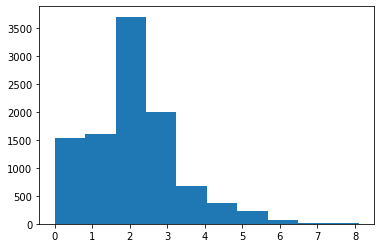

In [24]:
import matplotlib.pyplot as plt 
plt.hist(x)

In [35]:
tmp1 = tmp1.sort_values('encoded_activity').reset_index(drop = True)
for i, grp in  tmp1.groupby('encoded_activity'): 
    print(i)
    print(grp.index)

1
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
             91,  92,  93,  94,  95,  96,  97,  98,  99, 100],
           dtype='int64', length=101)
2
Int64Index([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
            114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
            127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
            140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
            153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
            166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
            179, 180, 181, 182, 183, 184, 185, 186],
           dtype='int64')
3
Int64Index([187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
            200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210],
           dtype='int64')
4
Int64Index([211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
            224, 225, 22

In [36]:
tmp1

,feature_1,feature_2,feature_3,user_id,encoded_activity
0,3.801953,9.931250,-0.510234,1,1
1,-8.302109,5.957891,-0.123984,1,1
2,-8.327734,6.161719,-0.095391,1,1
3,-8.337969,6.182812,-0.078594,1,1
4,-8.063203,5.927500,-0.274922,1,1
...,...,...,...,...,...
230,-6.075703,8.751875,0.696406,1,4
231,-1.968672,10.468984,0.640781,1,4
232,-5.264062,6.089375,0.535078,1,4
233,6.548594,9.072812,0.398203,1,4


In [57]:
dist_mat = pd.DataFrame(sp.distance.cdist(tmp1.iloc[:, :3].values, 
                            tmp1.iloc[:, :3].values,
                            metric = 'mahalanobis'))
x = dist_mat.values.reshape(1,-1).ravel()
print(np.quantile(x, [0.1, 0.25, 0.5, 0.75, 0.9, 0.99]))

[0.62632135 1.27807965 2.4519086  3.01938972 3.46231877 4.02243838]


In [58]:
# 1 vs 1 
x= dist_mat.iloc[:100, :100].values.reshape(1,-1).ravel()
print(np.quantile(x, [0.1, 0.25, 0.5, 0.75, 0.9, 0.99]))

[0.29241292 0.65822706 2.49526229 3.32095772 3.64893451 4.04129326]


In [59]:
# 1 vs 2
x= dist_mat.iloc[:100, 101:186].values.reshape(1,-1).ravel()
print(np.quantile(x, [0.1, 0.25, 0.5, 0.75, 0.9, 0.99]))

[0.81581104 1.02772297 2.45861207 2.96133222 3.36613607 3.96695638]


In [63]:
# 2 vs 2
x= dist_mat.iloc[101:186, 101:186].values.reshape(1,-1).ravel()
print(np.quantile(x, [0.1, 0.25, 0.5, 0.75, 0.9, 0.99]))

[0.22605604 0.44316462 1.73149108 2.8620132  3.13409488 3.73180323]


In [60]:
# 1 vs 3
x= dist_mat.iloc[:100, 187:210].values.reshape(1,-1).ravel()
print(np.quantile(x, [0.1, 0.25, 0.5, 0.75, 0.9, 0.99]))

[1.46939197 2.05141805 2.40231691 2.88190799 3.37395023 3.85781854]


In [62]:
# 1 vs 4 
x= dist_mat.iloc[:100, 211:].values.reshape(1,-1).ravel()
print(np.quantile(x, [0.1, 0.25, 0.5, 0.75, 0.9, 0.99]))

[1.57461957 2.16633632 2.7634898  3.287306   3.65140674 4.31198969]
